In [1]:
import transformers
wavlm_model = transformers.AutoModel.from_pretrained(
        "facebook/wav2vec2-base"
    )

/home/wnakata/lightning-vocoders/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wnakata/lightning-vocoders/.venv/lib/python3.10/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2Model: ['quantizer.codevectors', 'quantizer.weight_proj.bias', 'project_q.weight', 'project_hid.bias', 'quantizer.weight_proj.weight', 'project_hid.weight', 'project_q.bias']
- This IS expected if you are initiali

In [2]:
processor = transformers.AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")
wavlm_model

/home/wnakata/lightning-vocoders/.venv/lib/python3.10/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [3]:
wavlm_model.feature_extractor

Wav2Vec2FeatureEncoder(
  (conv_layers): ModuleList(
    (0): Wav2Vec2GroupNormConvLayer(
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (activation): GELUActivation()
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
    )
    (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
  )
)

In [4]:
def calc_wavlm_length(x):
    def calc_conv_length(in_length,kernel,stride):
        return (in_length + (kernel -1 )-1)/stride

    x = calc_conv_length(x,10,5)
    x = calc_conv_length(x,3,2)
    x = calc_conv_length(x,3,2)
    x = calc_conv_length(x,3,2)
    x = calc_conv_length(x,3,2)
    x = calc_conv_length(x,2,2)
    x = calc_conv_length(x,2,2)
    return x

In [5]:
1/(calc_wavlm_length(160000000000000)/160000000000000)

319.99999999983396

In [6]:
import torchaudio
import torch
from pathlib import Path
from tqdm import tqdm
wav_files = list(Path("/mnt/hdd/datasets/jvs_ver1/").glob("**/*.wav"))
outputs = []
filenames = []
wavlm_model.to('cuda')
for wav_file in tqdm(wav_files):
    wav_tensor,sr = torchaudio.load(wav_file)
    wav_tensor = torchaudio.functional.resample(waveform=wav_tensor,orig_freq=sr,new_freq=16_000)
    inputs = processor(wav_tensor.squeeze(),return_tensors='pt',sampling_rate=16_000)
    inputs.to('cuda')
    with torch.no_grad():
        output = wavlm_model(**inputs,output_hidden_states=True)
    outputs.append(torch.stack(output.hidden_states).cpu().mean(axis=2).numpy())
    filenames.append(wav_file)


100%|██████████| 14997/14997 [03:51<00:00, 64.91it/s] 


In [7]:
import re 
speakers = [re.search(r"jvs\d\d\d",str(filename)).group(0) for filename in filenames]
with Path("/mnt/hdd/datasets/jvs_ver1/gender_f0range.txt").open() as f:
    lines = f.readlines()
gender  = dict()
_ = [gender.update({l.split()[0]:l.split()[1]}) for l in lines[1:]]

In [8]:
len(outputs)

14997

In [9]:
outputs[0].shape

(13, 1, 768)

/home/wnakata/lightning-vocoders/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/wnakata/lightning-vocoders/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/wnakata/lightning-vocoders/.venv/lib/python3.10/site-pac

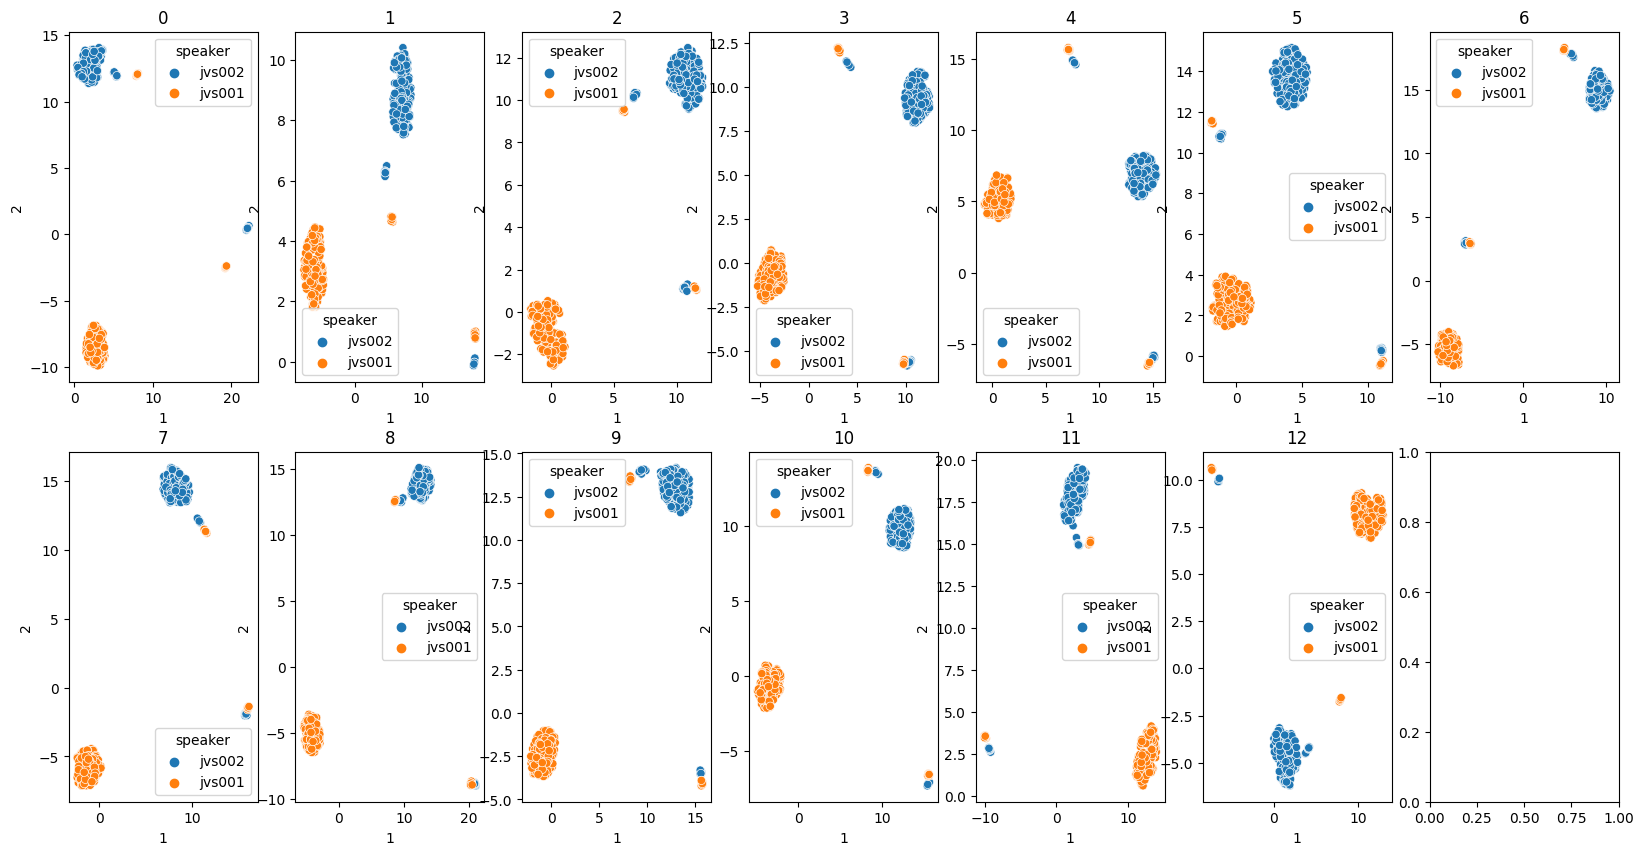

In [10]:
import umap
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
fig,ax = plt.subplots(2,7,figsize=(20,10))
for i in range(outputs[0].shape[0]):
    df = pd.DataFrame()
    df['speaker'] = speakers
    df['embedding'] = [o[i].squeeze(0) for o in outputs]
    plot_df = df[df['speaker'].str.contains('jvs001|jvs002',regex=True)]
    u = umap.UMAP().fit_transform( np.stack(plot_df['embedding'].to_list()))
    plot_df['1'] = u[:,0]
    plot_df['2'] = u[:,1]
    sns.scatterplot(data=plot_df,x='1',y='2',hue='speaker',ax=ax[i//7,i%7])
    ax[i//7,i%7].set_title(f"{i}")
plt.show()

In [11]:
outputs[0].shape

(13, 1, 768)

In [12]:
gender

{'jvs001': 'M',
 'jvs002': 'F',
 'jvs003': 'M',
 'jvs004': 'F',
 'jvs005': 'M',
 'jvs006': 'M',
 'jvs007': 'F',
 'jvs008': 'F',
 'jvs009': 'M',
 'jvs010': 'F',
 'jvs011': 'M',
 'jvs012': 'M',
 'jvs013': 'M',
 'jvs014': 'F',
 'jvs015': 'F',
 'jvs016': 'F',
 'jvs017': 'F',
 'jvs018': 'F',
 'jvs019': 'F',
 'jvs020': 'M',
 'jvs021': 'M',
 'jvs022': 'M',
 'jvs023': 'M',
 'jvs024': 'F',
 'jvs025': 'F',
 'jvs026': 'F',
 'jvs027': 'F',
 'jvs028': 'M',
 'jvs029': 'F',
 'jvs030': 'F',
 'jvs031': 'M',
 'jvs032': 'M',
 'jvs033': 'M',
 'jvs034': 'M',
 'jvs035': 'F',
 'jvs036': 'F',
 'jvs037': 'M',
 'jvs038': 'F',
 'jvs039': 'F',
 'jvs040': 'F',
 'jvs041': 'M',
 'jvs042': 'M',
 'jvs043': 'F',
 'jvs044': 'M',
 'jvs045': 'M',
 'jvs046': 'M',
 'jvs047': 'M',
 'jvs048': 'M',
 'jvs049': 'M',
 'jvs050': 'M',
 'jvs051': 'F',
 'jvs052': 'M',
 'jvs053': 'F',
 'jvs054': 'M',
 'jvs055': 'F',
 'jvs056': 'F',
 'jvs057': 'F',
 'jvs058': 'F',
 'jvs059': 'F',
 'jvs060': 'F',
 'jvs061': 'F',
 'jvs062': 'F',
 'jvs063

/tmp/ipykernel_3172014/2000843267.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['1'] = u[:,0]
/tmp/ipykernel_3172014/2000843267.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['2'] = u[:,1]


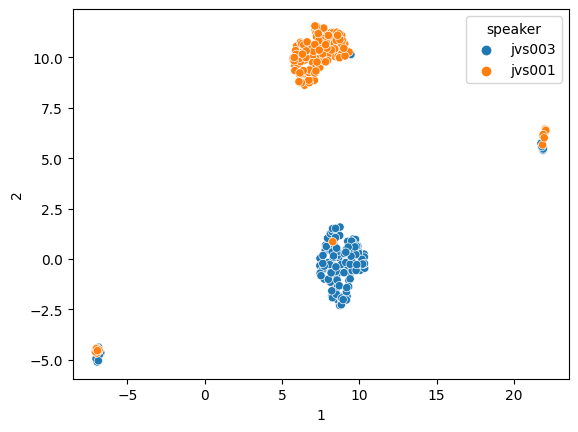

In [13]:
df = pd.DataFrame()
df['speaker'] = speakers
df['embedding'] = [o[-1].squeeze(0) for o in outputs]
plot_df = df[df['speaker'].str.contains('jvs001|jvs003',regex=True)]
u = umap.UMAP().fit_transform( np.stack(plot_df['embedding'].to_list()))
plot_df['1'] = u[:,0]
plot_df['2'] = u[:,1]
sns.scatterplot(data=plot_df,x='1',y='2',hue='speaker')
plt.show()

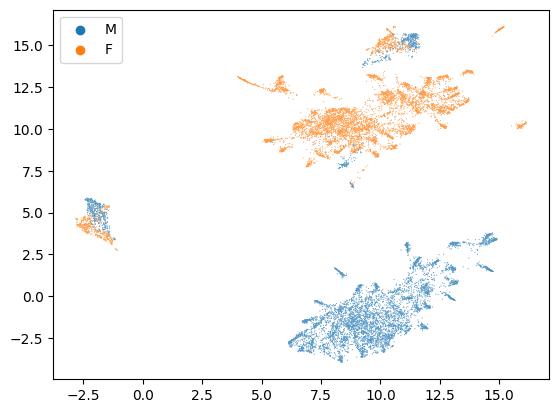

In [14]:
u = umap.UMAP().fit_transform( np.stack(outputs)[:,-1,:,:].squeeze(1))
sns.scatterplot(x=u[:,0],y=u[:,1],hue=np.stack([gender[s] for s in speakers]),s=0.5)
plt.show()

/tmp/ipykernel_3172014/2420583470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['1'] = u[:,0]
/tmp/ipykernel_3172014/2420583470.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['2'] = u[:,1]
/tmp/ipykernel_3172014/2420583470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

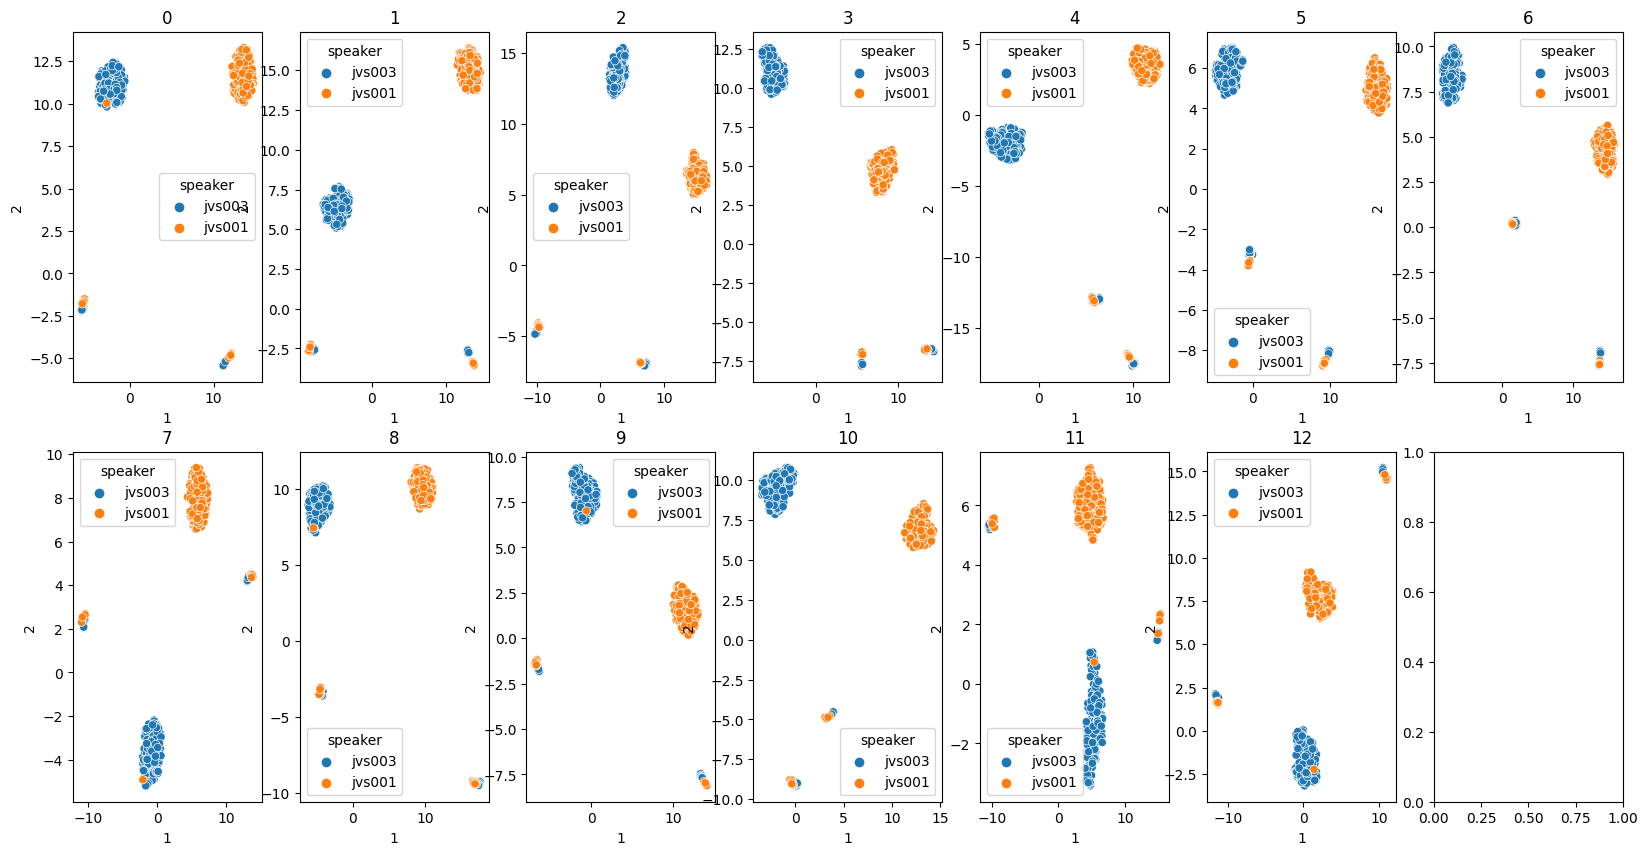

In [15]:
fig,ax = plt.subplots(2,7,figsize=(20,10))
for i in range(outputs[0].shape[0]):
    df = pd.DataFrame()
    df['speaker'] = speakers
    df['embedding'] = [o[i].squeeze(0) for o in outputs]
    plot_df = df[df['speaker'].str.contains('jvs001|jvs003',regex=True)]
    u = umap.UMAP().fit_transform( np.stack(plot_df['embedding'].to_list()))
    plot_df['1'] = u[:,0]
    plot_df['2'] = u[:,1]
    sns.scatterplot(data=plot_df,x='1',y='2',hue='speaker',ax=ax[i//7,i%7])
    ax[i//7,i%7].set_title(f"{i}")
plt.show()

In [16]:
np.stack(plot_df['embedding'].to_list()).shape

(300, 768)

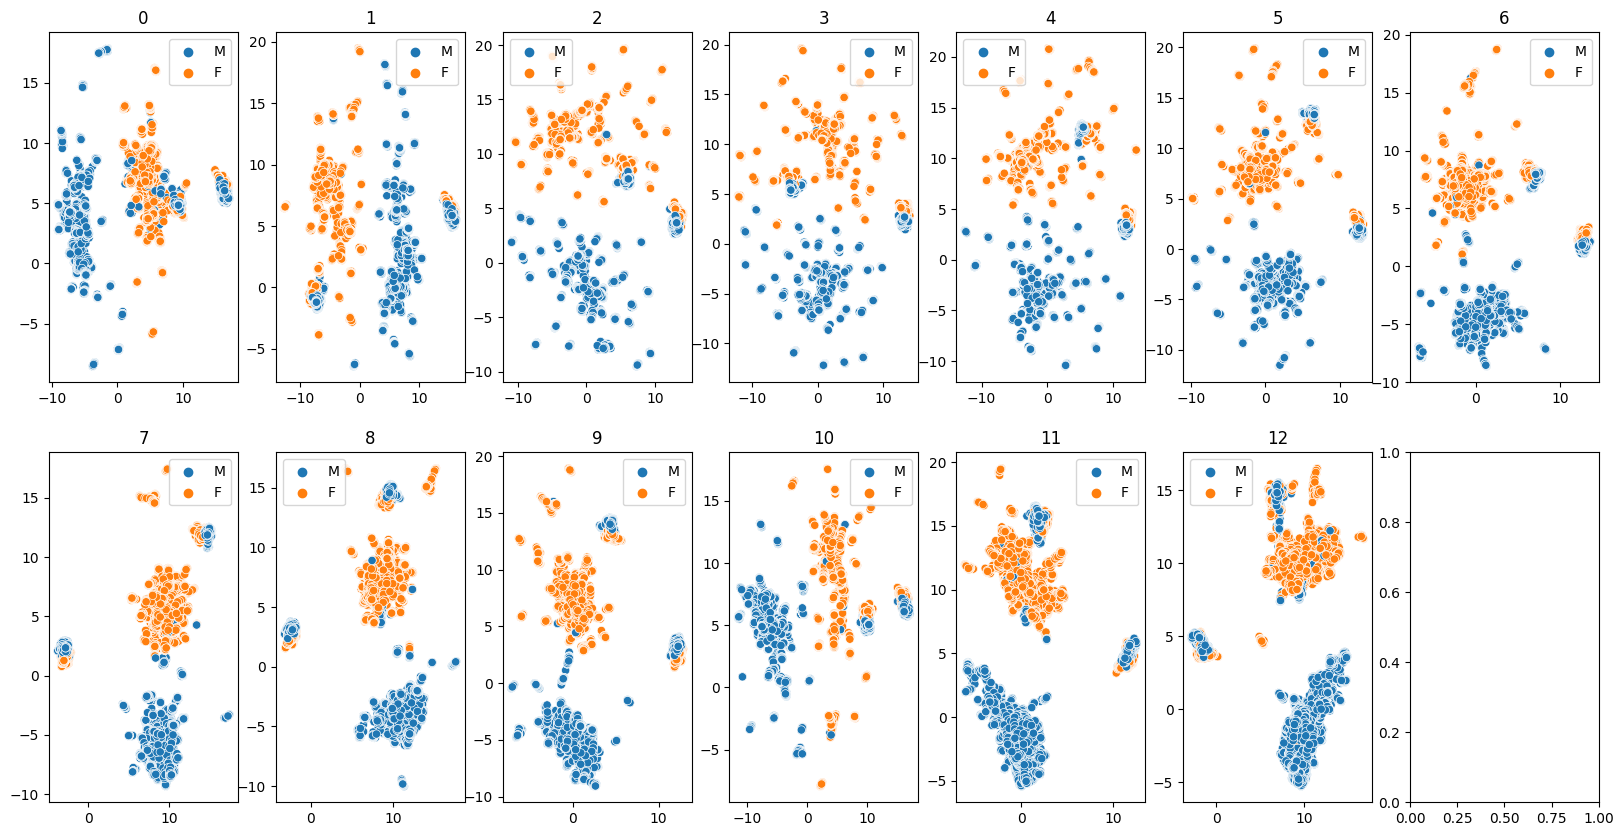

In [17]:
import umap
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
fig,ax = plt.subplots(2,7,figsize=(20,10))
for i in range(outputs[0].shape[0]):
    u = umap.UMAP().fit_transform( np.stack(outputs)[:,i,:,:].squeeze(1))
    sns.scatterplot(x=u[:,0],y=u[:,1],hue=np.stack([gender[s] for s in speakers]),ax=ax[i//7,i%7])
    ax[i//7,i%7].set_title(f"{i}")
plt.show()

In [18]:
import torchaudio
import torch
from pathlib import Path
from tqdm import tqdm
import random
wav_files = list(Path("/mnt/hdd/datasets/jvs_ver1/").glob("**/VOICEACTRESS100_*.wav"))
wav_files = random.sample(wav_files,1000)
phoneme_outputs = []
filenames = []
wavlm_model.to('cuda')
outputs = []
speakers = []
for wav_file in tqdm(wav_files):
    alignment_file = Path(f"/mnt/hdd/datasets/jvs_ver1/jvs_r9y9-dev/aligned_labels_openjtalk/{wav_file.parents[2].name}/{wav_file.stem}.lab")
    if not alignment_file.exists():
        continue
    with alignment_file.open() as f:
        lines = f.readlines()
    wav_tensor,sr = torchaudio.load(wav_file)
    wav_tensor = torchaudio.functional.resample(waveform=wav_tensor,orig_freq=sr,new_freq=16_000)
    inputs = processor(wav_tensor.squeeze(),return_tensors='pt',sampling_rate=16_000)
    inputs.to('cuda')
    with torch.no_grad():
        output = wavlm_model(**inputs,output_hidden_states=True)
    speaker = wav_file.parents[2].name
    for l in lines:
        s,e,p = l.strip().split()
        start_index = int(float(s)*16_000/320.0)
        end_index = int(float(e)*16_000/320.0)

        outputs.append(torch.stack(output.hidden_states)[:,:,start_index:end_index,:].mean(axis=2).squeeze().cpu().numpy())
        phoneme_outputs.append(p)
        speakers.append(speaker)
        filenames.append(wav_file)

100%|██████████| 1000/1000 [02:24<00:00,  6.94it/s]


In [19]:
for output in outputs:
    if output.shape != (13,768):
        print(output.shape)
np.stack(outputs).shape

(76453, 13, 768)

In [20]:
np.isnan(np.stack(outputs)[:,0]).any(axis=1).shape

(76453,)

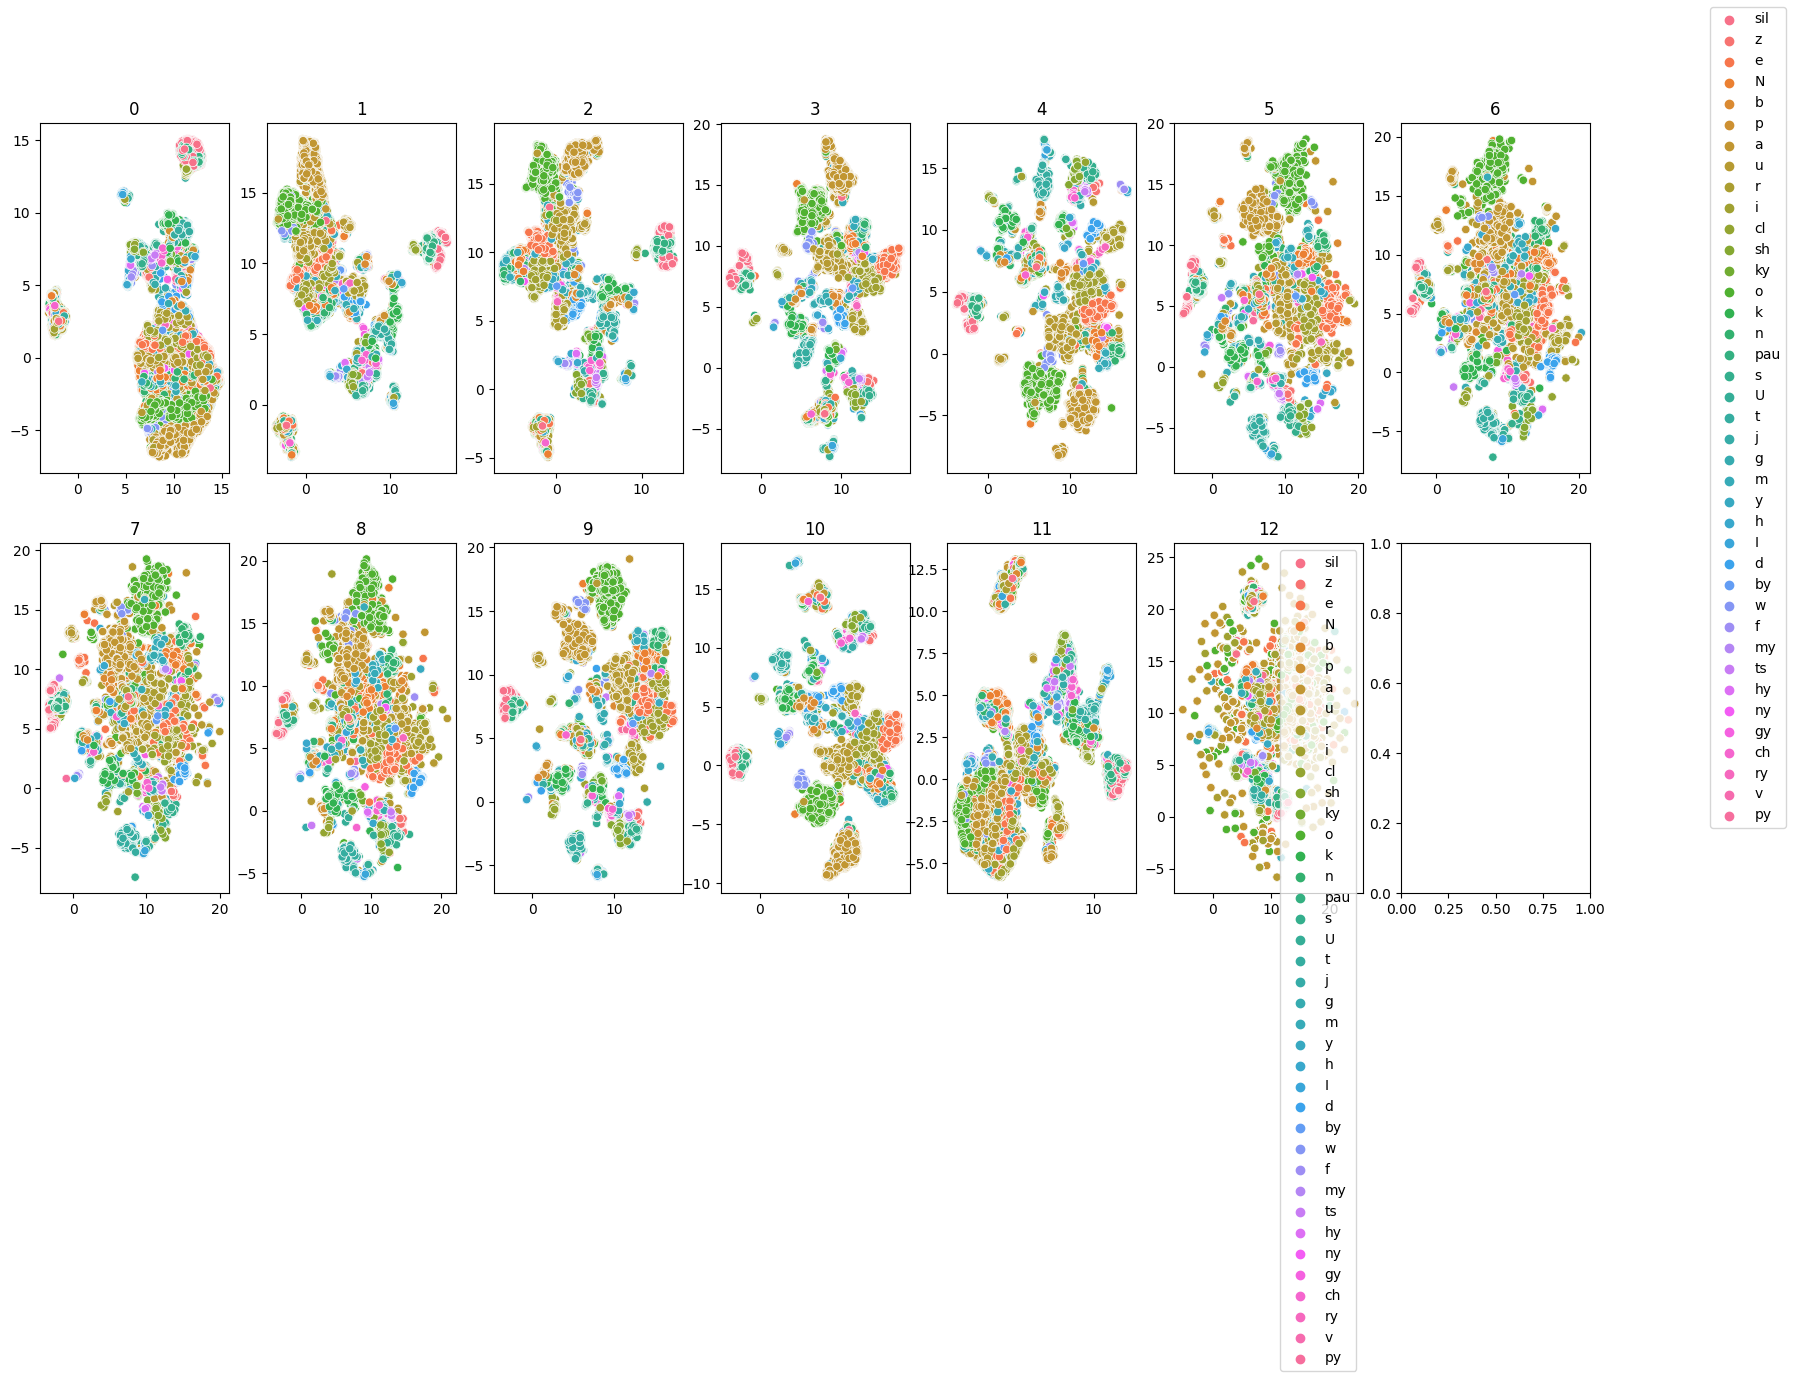

In [21]:
import umap
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
fig,ax = plt.subplots(2,7,figsize=(20,10))
for i in range(outputs[0].shape[0]):
    u = umap.UMAP().fit_transform( np.stack(outputs)[~np.isnan(np.stack(outputs)[:,i]).any(axis=1),i])
    sns.scatterplot(x=u[:,0],y=u[:,1],hue=np.stack(phoneme_outputs)[~np.isnan(np.stack(outputs)[:,i]).any(axis=1)],ax=ax[i//7,i%7])
    ax[i//7,i%7].set_title(f"{i}")
    if i != (outputs[0].shape[0] -1):
        ax[i//7,i%7].get_legend().remove()
handles, labels = ax[i//7,i%7].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

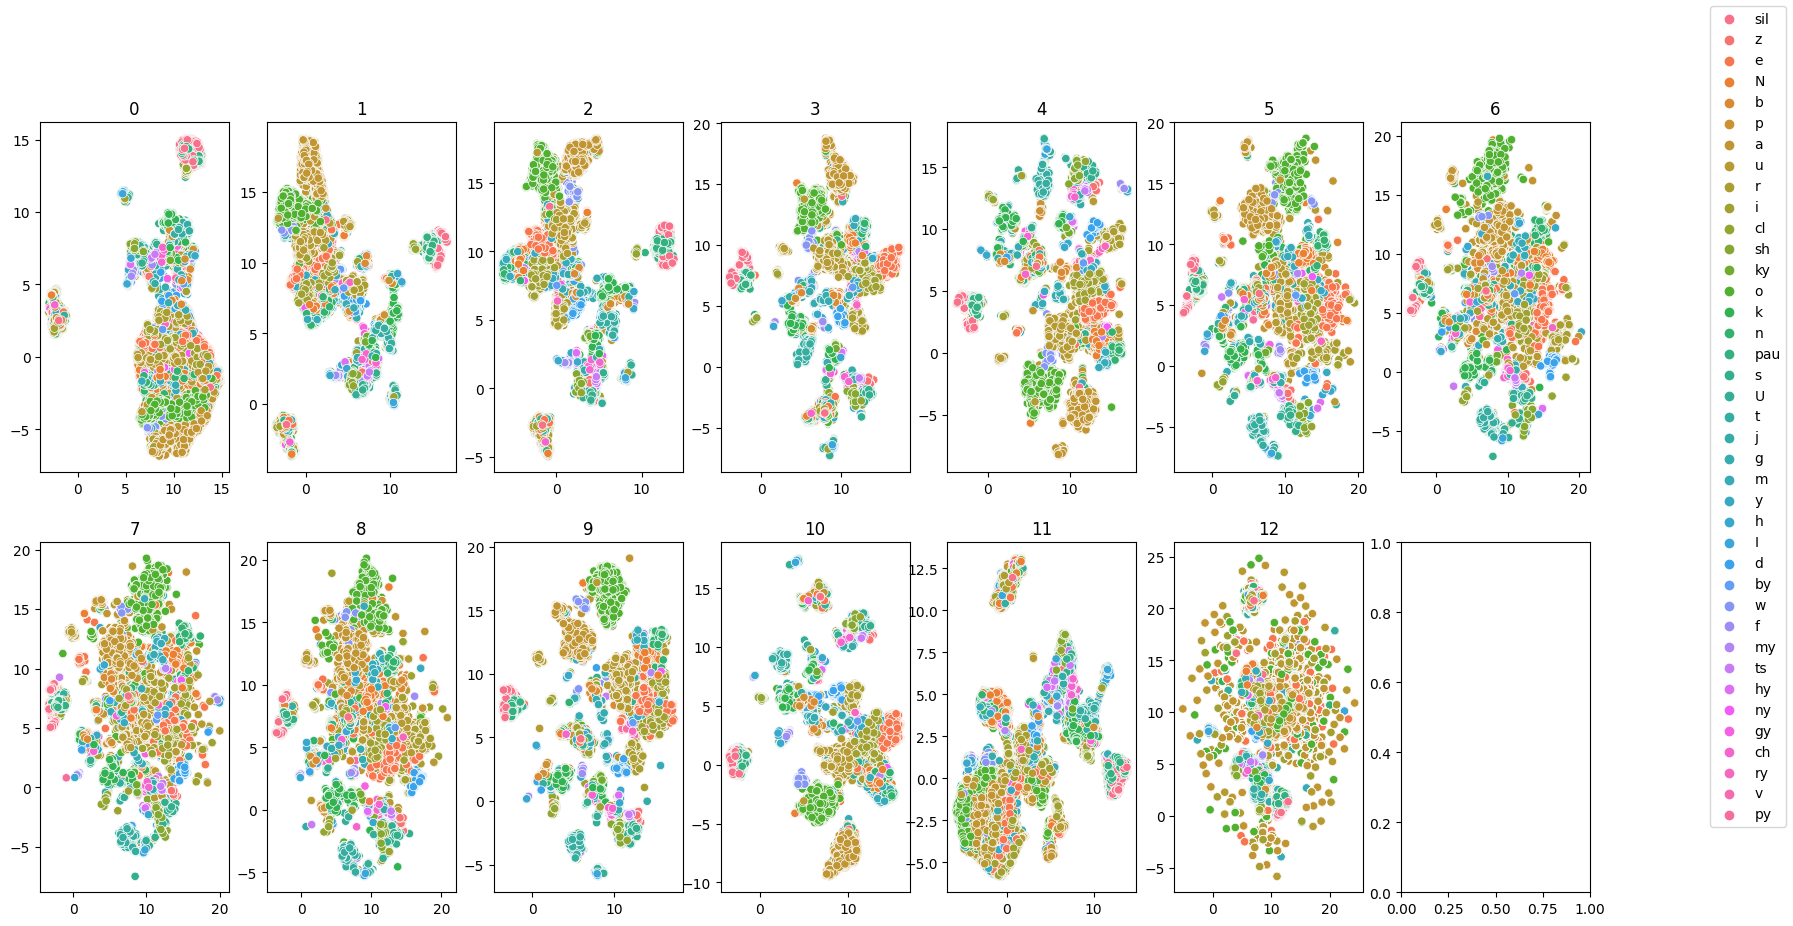

In [22]:
ax[i//7,i%7].get_legend().remove()
fig

In [29]:
np.stack(outputs)[~np.isnan(np.stack(outputs)[:,-1]).any(axis=1),:].shape

(76431, 13, 768)

In [30]:
from matplotlib import pyplot as plt
import pandas as pd
df = pd.DataFrame()
u = umap.UMAP().fit_transform( np.stack(outputs)[~np.isnan(np.stack(outputs)[:,-1]).any(axis=1),-1])
df['embedding_1'] = u[:,0]
df['embedding_2'] = u[:,1]
df['phones'] = np.stack(phoneme_outputs)[~np.isnan(np.stack(outputs)).any(axis=1)]

KeyboardInterrupt: 

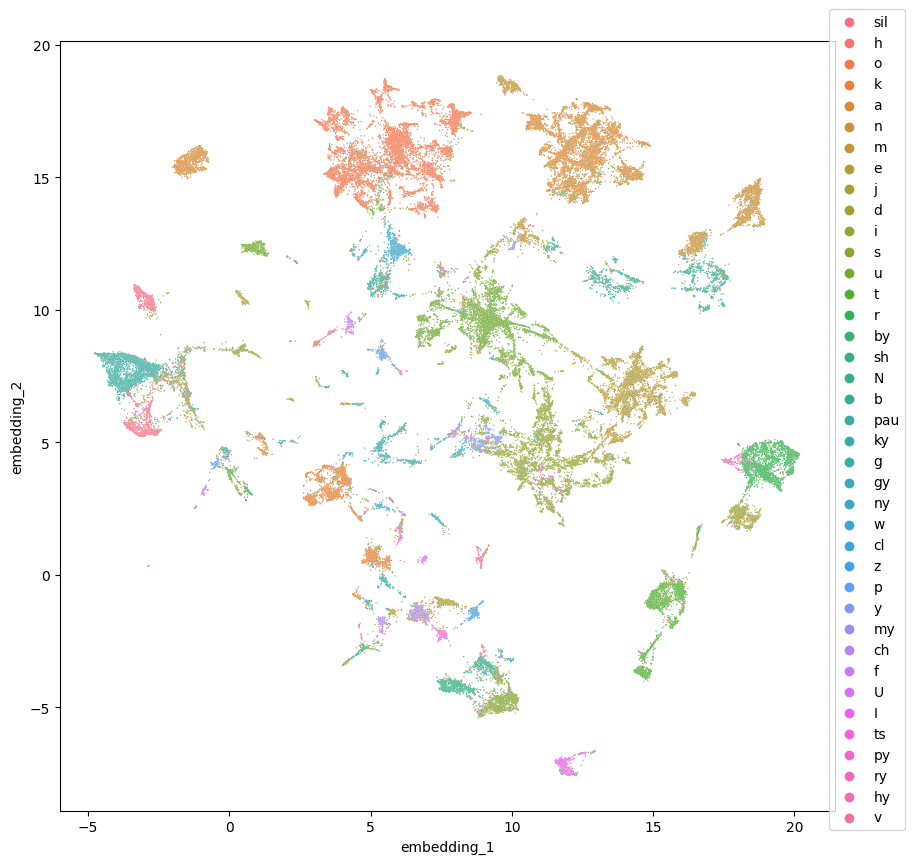

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data=df,x='embedding_1',y='embedding_2',hue='phones',s=1)
ax.legend(bbox_to_anchor=(1.1, 1.05))